In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
w.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
keywords_to_tumor_df = pd.read_csv('keyword2tumor_type.csv')

In [3]:
train_df.head()

,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


In [4]:
train_df.drop(columns='url',inplace=True)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   doc_id  100 non-null    int64
 1   label   100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


no null values

### DATA PREPROCESSING

In [6]:
# extract test from html files 
import os 
from bs4 import BeautifulSoup
html_path = "htmls/"

def html_to_text(doc_id):
    file_path = os.path.join(html_path, f'{doc_id}.html')
    if not os.path.exists(file_path):
        print('File not found')
        return ""
    
    with open(file_path,'r', encoding='latin-1') as f:
        content = f.read()
    
    soup = BeautifulSoup(content)
    clean_text = soup.get_text(' ')
    return clean_text.strip()



In [7]:
train_df['text'] = train_df['doc_id'].apply(html_to_text)
test_df['text'] = test_df['doc_id'].apply(html_to_text)

In [8]:
train_df.text.head(1).values[0]

'Elbe-Elster Klinikum - Chirurgie Finsterwalde \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n   \n \n \n   \n \n Suchen ...     \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n   \n Elbe-Elster Klinikum   \n \n   \n Leitbild   \n \n   \n Klinikleitung   \n \n \n QualitÃ¤tsmanagement   \n \n   \n QualitÃ¤tsberichte   \n \n \n Krankenhaushygiene   \n \n \n Beauftragte des Klinikums   \n \n \n Karriere / Ausbildung   \n \n   \n Stellenangebote   \n \n \n Ausbildung und Praktikum   \n \n \n Facharztausbildung   \n \n   \n Klinikum im Cartoon   \n \n \n Akademisches Lehrkrankenhaus MHB   \n \n \n Elbe-Elster MVZ GmbH   \n \n   \n Standorte   \n \n   \n Elsterwerda   \n \n   \n Finsterwalde   \n \n   \n Herzberg   \n \n   \n Fachbereiche   \n \n \n AnÃ¤sthesie und Intensivmedizin   \n \n \n AnÃ¤sthesie und Intensivmedizin Elsterwerda   \n \n \n AnÃ¤sthesie und I

In [9]:
# removing extra space and special characters
import re
def filter_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]','', text)
    return text

In [10]:
train_df['proper_text'] = train_df['text'].apply(filter_text)
test_df['proper_text'] = test_df['text'].apply(filter_text)

In [11]:
len(train_df['proper_text'].head(1).values[0])

8780

Now the data looks more clean . After searching the internet the language seems to be german. So remving all the stopwords

In [12]:
import nltk 
from nltk.corpus import stopwords
import string 

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

Language present in text is german

In [13]:
stop_words = set(stopwords.words('german'))
def remove_stopwords(text):
    words = nltk.word_tokenize(text,language='german')
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
    return ' '. join(filtered_words)


In [14]:
train_df['filtered_text'] = train_df.proper_text.apply(remove_stopwords)
test_df['filtered_text'] = test_df.proper_text.apply(remove_stopwords)

In [15]:
len(train_df.filtered_text.head(1).values[0]) # we have remove a lot of stopwords from our text

7728

In [16]:
# performing lemmatization
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text,language='german')
    lemmatize_text = [lemmatizer.lemmatize(word.lower()) for word in words]
    return ' '.join(lemmatize_text)


In [17]:
train_df['lemmatized_text'] = train_df.filtered_text.apply(lemmatize_text)
test_df['lemmatized_text'] = test_df.filtered_text.apply(lemmatize_text)

In [18]:
len(train_df.lemmatized_text.head(1).values[0])

7727

In [19]:
keywords_to_tumor_df.head()

,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


In [20]:
# finding keywords in text
def keywords_in_text(text, keywords_df):
    found_keywords = []
    for _, row in keywords_df.iterrows():
        keyword = row['keyword']
        if keyword.lower() in text.lower():
            found_keywords.append(keyword)
    return found_keywords
# mapping tumor type according to the keyowrds
def map_tumor_type(text, keyword_df):
    if isinstance(text, list):
        text = ' '.join(text)
    
    keyword_dict = dict(zip(keyword_df['keyword'], keyword_df['tumor_type']))
    for keyword, tumor_type in keyword_dict.items():
        if keyword.lower() in text.lower():
            return tumor_type
    return None




In [21]:
train_df['keywords'] = train_df.lemmatized_text.apply(lambda x: keywords_in_text(x, keywords_to_tumor_df))
test_df['keywords'] = test_df.lemmatized_text.apply(lambda x: keywords_in_text(x,keywords_to_tumor_df))


In [22]:
train_df['tumor_type'] = train_df.keywords.apply(lambda x: map_tumor_type(x, keywords_to_tumor_df))
test_df['tumor_type'] = test_df.keywords.apply(lambda x: map_tumor_type(x, keywords_to_tumor_df))

In [23]:
# Remove square brackets and extra spaces
train_df['keywords'] = train_df['keywords'].apply(lambda x: str(x).strip('[]').replace("'", "").replace('"', '').strip())
test_df['keywords'] = test_df['keywords'].apply(lambda x: str(x).strip('[]').replace("'", "").replace('"', '').strip())


In [24]:
test_df.drop(columns='url',inplace=True)
test_df.head()

,doc_id,text,proper_text,filtered_text,lemmatized_text,keywords,tumor_type
0,0,"BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, ...",bauchspeicheldrã¼se klinik fã¼r allgemein vis...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,"viszeralchirurgie, galle, leber, magen, pankre...",Darm
1,2,Chirurgie der BauchspeicheldrÃ¼se (Pankreaschi...,chirurgie der bauchspeicheldrã¼se pankreaschir...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,"thorax, viszeralchirurgie, viszeralchirurgisch...",Brust
2,7,Brustzentrum Reutlingen: Behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren k...,brustzentrum reutlingen behandlungsverfahren k...,"brustzentrum, endokrine, mamma, pankreas, pros...",Brust
3,15,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust
4,16,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust


In [25]:
train_df.head()

,doc_id,label,text,proper_text,filtered_text,lemmatized_text,keywords,tumor_type
0,1,1,Elbe-Elster Klinikum - Chirurgie Finsterwalde ...,elbeelster klinikum chirurgie finsterwalde su...,elbeelster klinikum chirurgie finsterwalde suc...,elbeelster klinikum chirurgie finsterwalde suc...,"senologische, brustzentrum, viszeralchirurgie,...",Brust
1,3,3,Onkologisches Zentrum - Klinikum Bayreuth \n \...,onkologisches zentrum klinikum bayreuth aktue...,onkologisches zentrum klinikum bayreuth aktuel...,onkologisches zentrum klinikum bayreuth aktuel...,"brustzentrum, thorax, rektum, viszeralchirurgi...",Brust
2,4,1,Zentrum - SozialpÃ¤diatrisches Zentrum - StÃ¤d...,zentrum sozialpãdiatrisches zentrum stãdtisc...,zentrum sozialpãdiatrisches zentrum stãdtische...,zentrum sozialpãdiatrisches zentrum stãdtische...,"urologische, schwerpunkt",Urologische
3,5,1,Leistung - Spezielle UnterstÃ¼tzung bei der An...,leistung spezielle unterstã¼tzung bei der anm...,leistung spezielle unterstã¼tzung anmeldung ge...,leistung spezielle unterstã¼tzung anmeldung ge...,,None
4,6,3,Zuweiser - Tumorkonferenzen - Tumorkonferenz G...,zuweiser tumorkonferenzen tumorkonferenz gas...,zuweiser tumorkonferenzen tumorkonferenz gastr...,zuweiser tumorkonferenzen tumorkonferenz gastr...,"viszeralchirurgie, gastroenterologie, gastroin...",Darm


In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow = CountVectorizer()
x_bow = bow.fit_transform(train_df['lemmatized_text'])


In [27]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(train_df['lemmatized_text'])


In [28]:
from sklearn.model_selection import train_test_split
X1 = x_tfidf
y = train_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=22)

# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_pred, y_test)

print("TFIDF Accuracy:", acc)
print("Confusion Matrix:\n",confusion_matrix(y_pred, y_test))

TFIDF Accuracy: 0.7
Confusion Matrix:
 [[ 0  0  0]
 [ 5 14  1]
 [ 0  0  0]]


In [30]:
X2 = x_bow
y=train_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=22)


In [31]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print("BOW Accuracy: ", acc)
print("Confusion Matrix:\n",confusion_matrix(y_pred, y_test))

BOW Accuracy:  0.75
Confusion Matrix:
 [[ 1  0  0]
 [ 4 14  1]
 [ 0  0  0]]


In [32]:
# considering BOW

In [33]:
# tunning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 5],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2']  # Feature selection
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [34]:
best_clf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_clf.fit(X_train, y_train)

# Evaluate
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")

Optimized Random Forest Accuracy: 0.7500


There is no change in accuracy so we keep our accuracy at 75

### Predicting labels for test data

In [35]:
# test data 
test_df.head()

,doc_id,text,proper_text,filtered_text,lemmatized_text,keywords,tumor_type
0,0,"BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, ...",bauchspeicheldrã¼se klinik fã¼r allgemein vis...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,"viszeralchirurgie, galle, leber, magen, pankre...",Darm
1,2,Chirurgie der BauchspeicheldrÃ¼se (Pankreaschi...,chirurgie der bauchspeicheldrã¼se pankreaschir...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,"thorax, viszeralchirurgie, viszeralchirurgisch...",Brust
2,7,Brustzentrum Reutlingen: Behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren k...,brustzentrum reutlingen behandlungsverfahren k...,"brustzentrum, endokrine, mamma, pankreas, pros...",Brust
3,15,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust
4,16,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust


In [36]:
X_test_bow = bow.transform(test_df['lemmatized_text'])
y_test_pred = clf.predict(X_test_bow)
test_df['Predicted_label'] = y_test_pred
test_df.head()

,doc_id,text,proper_text,filtered_text,lemmatized_text,keywords,tumor_type,Predicted_label
0,0,"BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, ...",bauchspeicheldrã¼se klinik fã¼r allgemein vis...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,bauchspeicheldrã¼se klinik fã¼r allgemein visz...,"viszeralchirurgie, galle, leber, magen, pankre...",Darm,2
1,2,Chirurgie der BauchspeicheldrÃ¼se (Pankreaschi...,chirurgie der bauchspeicheldrã¼se pankreaschir...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,chirurgie bauchspeicheldrã¼se pankreaschirurgi...,"thorax, viszeralchirurgie, viszeralchirurgisch...",Brust,2
2,7,Brustzentrum Reutlingen: Behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren ...,brustzentrum reutlingen behandlungsverfahren k...,brustzentrum reutlingen behandlungsverfahren k...,"brustzentrum, endokrine, mamma, pankreas, pros...",Brust,1
3,15,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust,2
4,16,Leistungsspektrum: Sankt Marien-Hospital Buer ...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,leistungsspektrum sankt marienhospital buer gm...,"brustzentrum, rektum, viszeralchirurgie, visze...",Brust,2


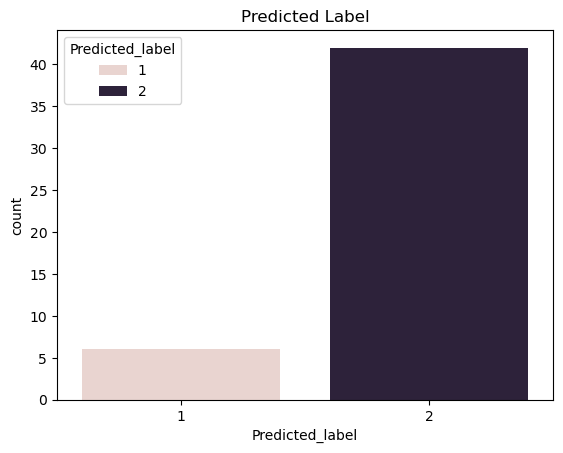

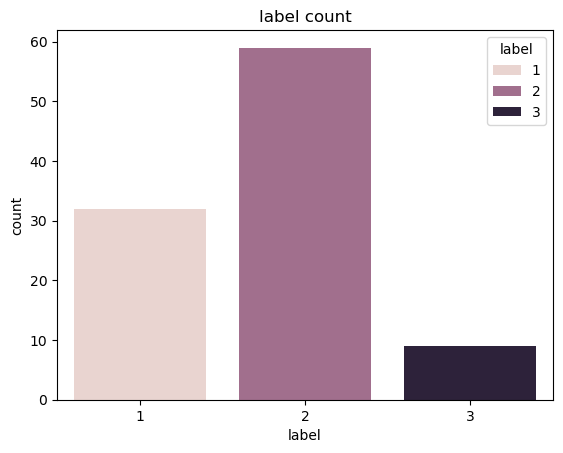

In [41]:
sns.countplot(x='Predicted_label', hue='Predicted_label', data=test_df)
plt.title("Predicted Label")
plt.show()

sns.countplot(x='label', hue='label', data=train_df)
plt.title("label count")
plt.show()

# Practicalities

#### How did you decide to handle this amount of data?
- After looking carefully at the data , it seemed that the data can be converged into a single table. All the text from html files, keywords and tumor type in train and test data .


#### How did you decide to do feature engineering? 
- For feature engineering, using NLP is the best way as there is text data and NLP handles text data very well. Firstly, removed all the unwanted space and characters. As the language used in text is german, so removed all the stopwords of german lanugage. Then done lemmatization of text.

####  How did you decide which models to try (if you decide to train any models)? 
- After trying logistic regression, SVM, Decision tree, Random Forest, Neural Network, Random Forest has performed very well with accuracy of 75 with BOW and 70 with TFIDF

#### How did you perform validation of your model?
- For validation , splitted the train data by 80/20 percentage for train/test. Then by training the model, used test_df data for predicting the requored labels

#### What metrics did you measure?

- Used accuracy score and confusion matrix
- BOW Accuracy:  0.75
- Confusion Matrix:
 [[ 1  0  0]
 [ 4 14  1]
 [ 0  0  0]]

#### How do you expect your model to perform on test data (in terms of your metrics)?
- The model has perform quite good on the test data with accuracy of 75% 

#### How fast will your algorithm performs and how could you improve its performance if you would have more time?
- Algorithm is very fast and predicts the output with accuracy. To improve the model performance more data is required as the available is small to capture the patterns and trends. Also fine tunning the model will increase the performance

#### How do you think you would be able to improve your algorithm if you would have more data? What potential issues do you see with your algorithm?
- Yes, i would be able to improve the model accuracy with more data. The potential issues with the algorithm is lack of data, as we had only limited data to capture the main trends of data which lead to slight underfitting. With more data the algorithm can easily perform better.

# Conclusion


#### **Bag of Words (BoW) Model:**
- **Accuracy:** **75%**  
- **Confusion Matrix:**
[[ 1 0 0] [ 4 14 1] [ 0 0 0]]

- The model performs **well on class 2**, but **misclassifies some class 1 samples into class 2**.
- **Class 3 has zero predictions**, indicating an issue with class imbalance.

#### **TF-IDF Model:**

- **Accuracy:** **70%**  
- **Confusion Matrix:**
[[ 0 0 0] [ 5 14 1] [ 0 0 0]]

- Similar performance to BoW, suggesting that TF-IDF **does not significantly improve classification**.
- **Class 3 remains unpredicted**, indicating potential data distribution issues.


